Import Libraries

In [101]:
import io, os, json, gzip 
import pandas as pd
import numpy as np
from google.colab import files, drive
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from matplotlib import pyplot as pplt
%matplotlib inline

Import Dataset

In [102]:
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [103]:
# unzip all data in local env
!unzip gdrive/My\ Drive/fer2013/fer2013.zip > /dev/null

replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


       angry  fear  disgust  happy   sad  surprise  neutral
train   3995  4097      436   7215  4830      3171     4965


<Axes: >

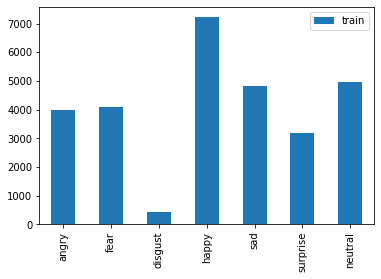

In [104]:
train_dir = 'train/'
test_dir = 'test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        if expression == ".ipynb_checkpoints":
          continue
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
train_count.transpose().plot(kind='bar')

Images as Matrix

In [125]:
# making n X m matrix
def img2np(path, list_of_filenames, size = (48,48)):
  # iterate through each file per emotion
  for fn in list_of_filenames:
      fp = path + fn
      current_image = image.load_img(fp, target_size = size, 
                                      color_mode = 'grayscale')
      # covert image to a matrix
      img_ts = image.img_to_array(current_image)
      # turn that into a vector / 1D array
      img_ts = [img_ts.ravel()]
      try:
          # concatenate different images
          full_mat = np.concatenate((full_mat, img_ts))
      except UnboundLocalError: 
          # if not assigned yet, assign one
          full_mat = img_ts
  return full_mat

surprise_imgs = [fn for fn in os.listdir(f'{train_dir}/surprise') if fn.endswith('.jpg')]
disgust_imgs = [fn for fn in os.listdir(f'{train_dir}/disgust') if fn.endswith('.jpg')]
fear_imgs = [fn for fn in os.listdir(f'{train_dir}/fear') if fn.endswith('.jpg')]
happy_imgs = [fn for fn in os.listdir(f'{train_dir}/happy') if fn.endswith('.jpg')]
neutral_imgs = [fn for fn in os.listdir(f'{train_dir}/neutral') if fn.endswith('.jpg')]
sad_imgs = [fn for fn in os.listdir(f'{train_dir}/sad') if fn.endswith('.jpg')]
angry_imgs = [fn for fn in os.listdir(f'{train_dir}/angry') if fn.endswith('.jpg')]

# run it on our folders
emotion = ['surprise', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'angry']
emotion_imgs = [surprise_imgs, disgust_imgs, fear_imgs, happy_imgs, neutral_imgs, sad_imgs, angry_imgs]

def matrixImages(emotion, emotion_imgs):
  result = []
  for i in range(len(emotion)):
    img = img2np(f'{train_dir}/{emotion[i]}/', emotion_imgs[i])
    result.append(img)
  return result

matrix_images = matrixImages(emotion, emotion_imgs)


Mean Images

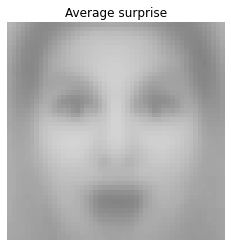

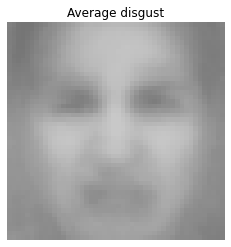

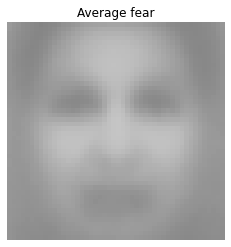

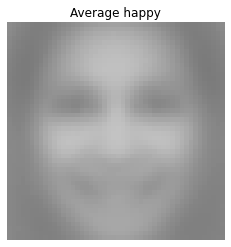

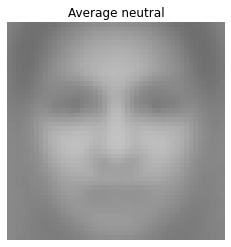

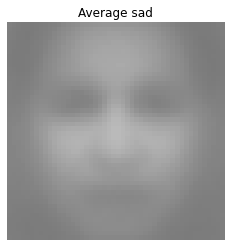

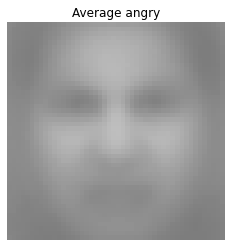

In [126]:
def find_mean_img(full_mat, title, size = (48,48)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r', alpha=1)
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

for i in range(len(emotion)):
    find_mean_img(matrix_images[i], emotion[i])

Model Training

In [127]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator



SVM with disgust

In [128]:
datagen = ImageDataGenerator(rescale=1./255)
train_set = datagen.flow_from_directory(train_dir, target_size=(48, 48),
                                              batch_size=32, color_mode='grayscale',
                                              class_mode='categorical', seed=1)
test_set = datagen.flow_from_directory(test_dir, target_size=(48, 48),
                                             batch_size=32, color_mode='grayscale',
                                              class_mode='categorical', seed=1)

X_train, y_train = train_set.next()
X_test, y_test = test_set.next()
X_train = X_train.reshape((-1, 48*48))
X_test = X_test.reshape((-1, 48*48))

# print(y_train)

def findIndex(lst):
  for i in range(len(lst)):
    if lst[i] == 1.0:
      return i

class_indices = {0 : 'angry', 
                 1 : 'disgust', 
                 2 : 'fear', 
                 3 : 'happy', 
                 4 : 'neutral', 
                 5 : 'sad', 
                 6 : 'surprise'}

y_train_fixed = []
for item in y_train:
  index = findIndex(item)
  y_train_fixed.append(class_indices[index])
y_train_data = np.array(y_train_fixed)

y_test_fixed = []
for item in y_test:
  index = findIndex(item)
  y_test_fixed.append(class_indices[index])
y_test_data = np.array(y_test_fixed)
  
hyperparam_k = ['linear', 'poly', 'rbf']
hyperparam_C = [0.01, 0.1, 1, 10, 100]
hyperparam_g = ['auto', 'scale']
hyperparam_dfs = ['ovo', 'ovr']

for k in hyperparam_k:
  for c in hyperparam_C:
    for g in hyperparam_g:
      for d in hyperparam_dfs:

        svm_model = SVC(kernel=k, C=c, gamma=g, decision_function_shape=d)
        # # Training the SVM model
        svm_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_data)
        # # Making predictions on the test data
        y_pred = svm_model.predict(X_test.reshape(X_test.shape[0], -1))

        # Calculating the accuracy and confusion matrix
        accuracy = accuracy_score(y_test_data, y_pred)
        conf_matrix = confusion_matrix(y_test_data, y_pred)

        print("Hyperparameters: kernel =", k, ", C =", c, ", gamma =", g, ", decision_function_shape =", d)
        print("Accuracy:", accuracy)
        print("Confusion Matrix:\n", conf_matrix)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Hyperparameters: kernel = linear , C = 0.01 , gamma = auto , decision_function_shape = ovo
Accuracy: 0.25
Confusion Matrix:
 [[0 0 0 0 3 0]
 [2 0 0 0 2 0]
 [1 0 4 0 3 0]
 [3 0 2 0 4 0]
 [1 0 1 0 4 0]
 [0 0 1 0 1 0]]
Hyperparameters: kernel = linear , C = 0.01 , gamma = auto , decision_function_shape = ovr
Accuracy: 0.25
Confusion Matrix:
 [[0 0 0 0 3 0]
 [2 0 0 0 2 0]
 [1 0 4 0 3 0]
 [3 0 2 0 4 0]
 [1 0 1 0 4 0]
 [0 0 1 0 1 0]]
Hyperparameters: kernel = linear , C = 0.01 , gamma = scale , decision_function_shape = ovo
Accuracy: 0.25
Confusion Matrix:
 [[0 0 0 0 3 0]
 [2 0 0 0 2 0]
 [1 0 4 0 3 0]
 [3 0 2 0 4 0]
 [1 0 1 0 4 0]
 [0 0 1 0 1 0]]
Hyperparameters: kernel = linear , C = 0.01 , gamma = scale , decision_function_shape = ovr
Accuracy: 0.25
Confusion Matrix:
 [[0 0 0 0 3 0]
 [2 0 0 0 2 0]
 [1 0 4 0 3 0]
 [3 0 2 0 4 0]
 [1 0 1 0 4 0]
 [0 0 1 0 1 0]]
Hyperparameters: kernel = linear , C = 0.1 , gamm

SVM without disgust

In [ ]:
# unzip all data in local env
!unzip gdrive/My\ Drive/fer2013v2/fer-2013-v2.zip
train_dir1 = 'train2/'
test_dir1 = 'test2/'

In [124]:
datagen = ImageDataGenerator(rescale=1./255)
train_set = datagen.flow_from_directory(directory=r"fer-2013-v2/train2/", target_size=(48, 48),
                                              batch_size=48, color_mode='grayscale',
                                              class_mode='categorical', seed=1)
test_set = datagen.flow_from_directory(directory=r"fer-2013-v2/test2/", target_size=(48, 48),
                                             batch_size=48, color_mode='grayscale',
                                              class_mode='categorical', seed=1)

X_train, y_train = train_set.next()
X_test, y_test = test_set.next()
X_train = X_train.reshape((-1, 48*48))
X_test = X_test.reshape((-1, 48*48))


# train_set.class_indices
# print(y_train)

def findIndex(lst):
  for i in range(len(lst)):
    if lst[i] == 1.0:
      return i

class_indices = {0 : 'angry', 
                 1 : 'fear', 
                 2 : 'happy', 
                 3 : 'neutral', 
                 4 : 'sad', 
                 5 : 'surprise'}

y_train_fixed = []
for item in y_train:
  index = findIndex(item)
  y_train_fixed.append(class_indices[index])
y_train_data = np.array(y_train_fixed)

y_test_fixed = []
for item in y_test:
  index = findIndex(item)
  y_test_fixed.append(class_indices[index])
y_test_data = np.array(y_test_fixed)
  
hyperparam_k = ['linear', 'poly', 'rbf']
hyperparam_C = [0.01, 0.1, 1, 10, 100]
hyperparam_g = ['auto', 'scale']
hyperparam_dfs = ['ovo', 'ovr']

for k in hyperparam_k:
  for c in hyperparam_C:
    for g in hyperparam_g:
      for d in hyperparam_dfs:

        svm_model = SVC(kernel=k, C=c, gamma=g, decision_function_shape=d)
        # # Training the SVM model
        svm_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_data)
        # # Making predictions on the test data
        y_pred = svm_model.predict(X_test.reshape(X_test.shape[0], -1))

        # Calculating the accuracy and confusion matrix
        accuracy = accuracy_score(y_test_data, y_pred)
        conf_matrix = confusion_matrix(y_test_data, y_pred)

        print("Hyperparameters: kernel =", k, ", C =", c, ", gamma =", g, ", decision_function_shape =", d)
        print("Accuracy:", accuracy)
        print("Confusion Matrix:\n", conf_matrix)

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.
Hyperparameters: kernel= linear , C= 0.01 , gamma= auto
Accuracy: 0.375
Confusion Matrix:
 [[ 3  2  3  0  3  0]
 [ 1  0  8  0  0  0]
 [ 0  0 13  0  1  0]
 [ 1  0  2  0  3  0]
 [ 0  0  3  0  2  0]
 [ 0  0  3  0  0  0]]
Hyperparameters: kernel= linear , C= 0.01 , gamma= auto
Accuracy: 0.375
Confusion Matrix:
 [[ 3  2  3  0  3  0]
 [ 1  0  8  0  0  0]
 [ 0  0 13  0  1  0]
 [ 1  0  2  0  3  0]
 [ 0  0  3  0  2  0]
 [ 0  0  3  0  0  0]]
Hyperparameters: kernel= linear , C= 0.01 , gamma= scale
Accuracy: 0.375
Confusion Matrix:
 [[ 3  2  3  0  3  0]
 [ 1  0  8  0  0  0]
 [ 0  0 13  0  1  0]
 [ 1  0  2  0  3  0]
 [ 0  0  3  0  2  0]
 [ 0  0  3  0  0  0]]
Hyperparameters: kernel= linear , C= 0.01 , gamma= scale
Accuracy: 0.375
Confusion Matrix:
 [[ 3  2  3  0  3  0]
 [ 1  0  8  0  0  0]
 [ 0  0 13  0  1  0]
 [ 1  0  2  0  3  0]
 [ 0  0  3  0  2  0]
 [ 0  0  3  0  0  0]]
Hyperparameters: kernel= linear , C= 0.1 